# High-dimensional Analyzers

@[Chaoming Wang](https://github.com/chaoming0625)

It's hard to analyze high-dimensional systems. However, we have to analyze high-dimensional systems.

Here, based on numerical optimization methods, BrainPy provides [brainpy.analysis.SlowPointFinder](../apis/auto/analysis/generated/brainpy.analysis.highdim.SlowPointFinder.rst) to help users find **slow points** (or **fixed points**) [1] for your high-dimensional dynamical systems.

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

bp.__version__

'2.3.0'

## What are slow points?

For the given system,

$$
\dot{x} = f(x),
$$

we wish to find values $x^∗$ around which the system is approximately linear. Using Taylor series expansion, we have

$$
f(x^* + \delta x) = f(x^*) + f'(x^*)\delta x + 1/2 \delta x f''(x^*) \delta x + \cdots
$$

We want the first derivative term (i.e., the linear term) to be dominant, which means $f(x^*) = 0$ or $f(x^*) \approx 0$. 

- For $f(x^*) \approx 0$ which is nonzero but small, we call the point $x^*$ a **slow point**. 
- More specially, if $f(x^*) = 0$, $x^*$ is a **fixed point**. 

## How to find slow points?

In order to find slow points, we can first define an auxiliary scalar function for your continous system $\dot{x} = f(x)$, 

$$
p(x) = |f(x)|^2.
$$

Or, if your system is discrete $x_n = f(x_{n-1})$, the auxiliary scalar function can be defined as

$$
p(x) = |x - f(x)|^2.
$$

If $x^*$ is a slow point, $p(x^*) \to 0$. 

Then, by minimizing the scalar function $p(x)$, we can get the candidate points for slow points and for further linearization. For the linear system, it's stability is evaluated by the eigenvalues of Jacobian matrix. 

Here, BrainPy provides [brainpy.analysis.SlowPointFinder](../apis/auto/analysis/generated/brainpy.analysis.highdim.SlowPointFinder.rst). It receives ``f_cell`` to specify the target function/object to analyze.

If the provided ``f_cell`` is a function, ``SlowPointFinder`` can supports to specify:

- ``f_type``: the type of the function (it can be "continuous" or "discrete").
- ``f_loss``: the loss function to minimize the optimization error.
- ``args``: extra arguments passed into the function when performing fixed point optimization.

If the provided ``f_cell`` is an instance of ``DynamicalSystem``, ``SlowPointFinder`` can supports to specify:

- ``f_loss``: the loss function to minimize the optimization error.
- ``args``: extra arguments passed into the defined ``update()`` function when performing fixed point optimization.
- ``inputs`` and ``fun_inputs``: inputs to this dynamical system. Similar to the inputs of ``DSRunner`` and ``DSTrainer``.
- ``target_vars``: the selected variables which are used to optimize fixed points. Other variables like "input" and "spike" can be ignored.

Then, ``brainpy.analysis.SlowPointFinder`` can help you:

- optimize to find the fixed/slow points with gradient descent algorithms (``find_fps_with_gd_method()``) or nonlinear optimization solver (``find_fps_with_opt_solver()``)
- exclude any fixed points whose losses are above threshold: ``filter_loss()``
- exclude any non-unique fixed points according to a tolerance: ``keep_unique()``
- exclude any far-away "outlier" fixed points: ``exclude_outliers()``
- computing the jacobian matrix for the given fixed/slow points: ``compute_jacobians()``

## Example 1: Decision Making Model

``brainpy.analysis.SlowPointFinder`` is aimed to find slow/fixed points of high-dimensional systems. Of course, it can optimize to find fixed points of low-dimensional systems. We take the 2D decision-making system as an example.

In [2]:
# parameters

gamma = 0.641  # Saturation factor for gating variable
tau = 0.06  # Synaptic time constant [sec]
a = 270.
b = 108.
d = 0.154

JE = 0.3725  # self-coupling strength [nA]
JI = -0.1137  # cross-coupling strength [nA]
JAext = 0.00117  # Stimulus input strength [nA]

mu = 20.  # Stimulus firing rate [spikes/sec]
coh = 0.5  # Stimulus coherence [%]
Ib1 = 0.3297
Ib2 = 0.3297

In [3]:
@bp.odeint
def int_s1(s1, t, s2, coh=0.5, mu=20.):
  I1 = JE * s1 + JI * s2 + Ib1 + JAext * mu * (1. + coh)
  r1 = (a * I1 - b) / (1. - bm.exp(-d * (a * I1 - b)))
  return - s1 / tau + (1. - s1) * gamma * r1

@bp.odeint
def int_s2(s2, t, s1, coh=0.5, mu=20.):
  I2 = JE * s2 + JI * s1 + Ib2 + JAext * mu * (1. - coh)
  r2 = (a * I2 - b) / (1. - bm.exp(-d * (a * I2 - b)))
  return - s2 / tau + (1. - s2) * gamma * r2

def step(s):
    ds1 = int_s1.f(s[0], 0., s[1])
    ds2 = int_s2.f(s[1], 0., s[0])
    return bm.asarray([ds1, ds2])

We first use [brainpy.analysis.PhasePlane2D](./lowdim_analysis.ipynb) to get the standard answer. 

In [4]:
analyzer = bp.analysis.PhasePlane2D(
    model=[int_s1, int_s2],
    target_vars={'s1': [0, 1], 's2': [0, 1]},
    resolutions=0.001,
)
analyzer.plot_fixed_point(select_candidates='aux_rank', with_plot=False)

I am searching fixed points ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 100 candidates
I am trying to filter out duplicate fixed points ...
	Found 3 fixed points.
	#1 s1=0.2827633321285248, s2=0.40635180473327637 is a saddle node.
	#2 s1=0.013946513645350933, s2=0.6573889851570129 is a stable node.
	#3 s1=0.7004518508911133, s2=0.004864312242716551 is a stable node.


Then, let's check whether the high-dimensional analyzer also works. 

In [5]:
finder = bp.analysis.SlowPointFinder(f_cell=step, f_type="continuous")
finder.find_fps_with_gd_method(
    candidates=bm.random.random((1000, 2)),
    tolerance=1e-5,
    num_batch=200,
    optimizer=bp.optimizers.Adam(bp.optimizers.ExponentialDecay(0.01, 1, 0.9999))
)
finder.filter_loss(1e-5)
finder.keep_unique()

Optimizing with Adam(lr=ExponentialDecay(0.01, decay_steps=1, decay_rate=0.9999), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 0.24 sec, Training loss 0.0510474481
    Batches 201-400 in 0.25 sec, Training loss 0.0046035680
    Batches 401-600 in 0.32 sec, Training loss 0.0007384720
    Batches 601-800 in 0.27 sec, Training loss 0.0001601687
    Batches 801-1000 in 0.25 sec, Training loss 0.0000381663
    Batches 1001-1200 in 0.25 sec, Training loss 0.0000088441
    Stop optimization as mean training loss 0.0000088441 is below tolerance 0.0000100000.
Excluding fixed points with squared speed above tolerance 1e-05:
    Kept 934/1000 fixed points with tolerance under 1e-05.
Excluding non-unique fixed points:
    Kept 3/934 unique fixed points with uniqueness tolerance 0.025.


In [6]:
finder.fixed_points

array([[0.28276306, 0.40635154],
       [0.7004519 , 0.00486429],
       [0.01394659, 0.6573889 ]], dtype=float32)

Yeah, the fixed points found by ``brainpy.analysis.PhasePlane2D`` and ``brainpy.analysis.SlowPointFinder`` are nearly the same. 

## Example 2: Continuous-attractor Neural Network

Continuous-attractor neural network [2] proposed by Si Wu is a special model which has a line of attractors. 

In [7]:
class CANN1D(bp.dyn.NeuGroup):
  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4., z_min=-bm.pi, z_max=bm.pi):
    super(CANN1D, self).__init__(size=num)

    # parameters
    self.tau = tau  # The synaptic time constant
    self.k = k  # Degree of the rescaled inhibition
    self.a = a  # Half-width of the range of excitatory connections
    self.A = A  # Magnitude of the external input
    self.J0 = J0  # maximum connection value

    # feature space
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)  # The encoded feature values
    self.rho = num / self.z_range  # The neural density
    self.dx = self.z_range / num  # The stimulus density

    # variables
    self.u = bm.Variable(bm.zeros(num))
    self.input = bm.Variable(bm.zeros(num))

    # The connection matrix
    self.conn_mat = self.make_conn(self.x)

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, u, t, Iext):
    r1 = bm.square(u)
    r2 = 1.0 + self.k * bm.sum(r1)
    r = r1 / r2
    Irec = bm.dot(self.conn_mat, r)
    du = (-u + Irec + Iext) / self.tau
    return du

  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  def make_conn(self, x):
    assert bm.ndim(x) == 1
    x_left = bm.reshape(x, (-1, 1))
    x_right = bm.repeat(x.reshape((1, -1)), len(x), axis=0)
    d = self.dist(x_left - x_right)
    Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
    return Jxx

  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, tdi):
    self.u.value = self.integral(self.u, tdi.t, self.input, tdi.dt)
    self.input[:] = 0.

  def cell(self, u):
    return self.derivative(u, 0., 0.)

In [8]:
cann = CANN1D(num=512, k=0.1, A=30)

The following code demonstrates how to use ``SlowPointFinder`` to find fixed points of a continuous attractor neural network.

In [9]:
# initialize an instance of slow point finder
finder = bp.analysis.SlowPointFinder(
    f_cell=cann,
    target_vars={'u': cann.u},
    dt=1.,
)

# we can initialize our candidate points with noisy bumps.
candidates = cann.get_stimulus_by_pos(bm.arange(-bm.pi, bm.pi, 0.01).reshape((-1, 1)))
candidates += bm.random.normal(0., 0.01, candidates.shape)

# optimize to find fixed points
finder.find_fps_with_opt_solver({'u': candidates})
finder.filter_loss(1e-6)
finder.keep_unique()

Optimizing with BFGS to find fixed points:
    Found 629 fixed points from 629 initial points.
Excluding fixed points with squared speed above tolerance 1e-06:
    Kept 357/629 fixed points with tolerance under 1e-06.
Excluding non-unique fixed points:
    Kept 357/357 unique fixed points with uniqueness tolerance 0.025.


The found fixed points are a series of attractor. We can visualize this line of attractors on a 2D space.

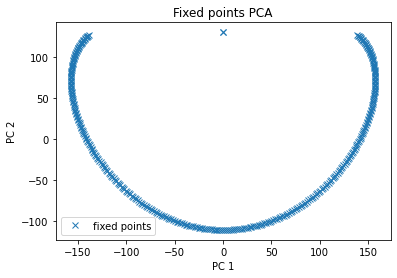

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(2)
fp_pcs = pca.fit_transform(finder.fixed_points['u'])
plt.plot(fp_pcs[:, 0], fp_pcs[:, 1], 'x', label='fixed points')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed points PCA')
plt.legend()
plt.show()

These fixed points can also be plotted on the feature space. In the following, we plot the selected points.

In [11]:
def visualize_fixed_points(fps, plot_ids=(0,), xs=None):
  for i in plot_ids:
    if xs is None:
      plt.plot(fps[i], label=f'FP-{i}')
    else:
      plt.plot(xs, fps[i], label=f'FP-{i}')
  plt.legend()
  plt.xlabel('Feature')
  plt.ylabel('Bump activity')
  plt.show()

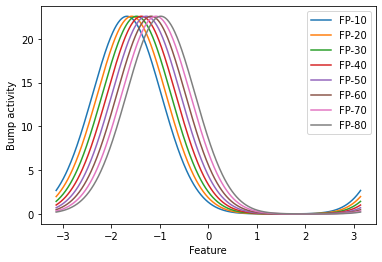

In [12]:
visualize_fixed_points(finder.fixed_points['u'],
                       plot_ids=(10, 20, 30, 40, 50, 60, 70, 80),
                       xs=cann.x)

Let's find the linear part or the Jacobian matrix around the fixed points. We decompose Jacobian matrix and then visualize its stability.

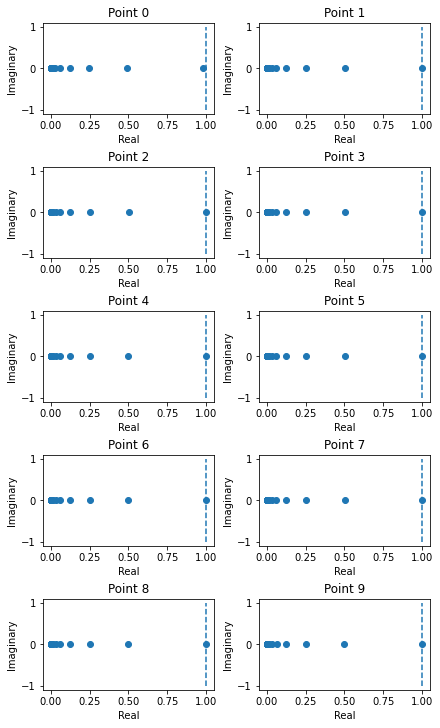

In [13]:
from jax import tree_map

# select the first ten fixed points
fps = tree_map(lambda a: a[:10], finder._fixed_points)

# compute jacobian and visualize the decomposed jacobian matrix
J = finder.compute_jacobians(fps, plot=True, num_col=2)

More examples of dynamics analysis, for example, analyzing the fixed points in a recurrent neural network, please see [BrainPy Examples](https://brainpy-examples.readthedocs.io/). 

## References

[1] Sussillo, D. , and  O. Barak . "Opening the Black Box: Low-Dimensional Dynamics in High-Dimensional Recurrent Neural Networks." Neural computation 25.3(2013):626-649.

[2] Si Wu, Kosuke Hamaguchi, and Shun-ichi Amari. “Dynamics and computation of continuous attractors.” Neural computation 20.4 (2008): 994-1025.